## Input kodekan ulang yang ada di Kaggle mulai bagian preporcessing, load model, dan test model

In [23]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
import csv
import itertools
import collections
import pywt
from scipy import stats
import pandas as pd
import os
import seaborn as sns
import numpy as np
%matplotlib inline

In [24]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [25]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.03 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [26]:
path = 'Test_data/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [27]:
print(X)
print(y)

[]
[]


In [28]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [29]:
print(filenames)

['101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '214.csv', '214annotations.txt', '217.csv', '217annotations.txt', '223.csv', '223annotations.txt']


In [30]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
print(records[0])
print(annotations[0])

Test_data/101.csv
Test_data/101annotations.txt


In [31]:
print(records)

['Test_data/101.csv', 'Test_data/102.csv', 'Test_data/116.csv', 'Test_data/117.csv', 'Test_data/118.csv', 'Test_data/119.csv', 'Test_data/121.csv', 'Test_data/214.csv', 'Test_data/217.csv', 'Test_data/223.csv']


In [32]:
def add_ecg_noise(signal, noise_type='baseline_wander'):
    if noise_type == 'baseline_wander':
        noise = 0.2 * np.sin(2 * np.pi * 0.5 * np.arange(len(signal)))
    elif noise_type == 'electrode_motion':
        noise = 0.2 * np.random.randn(len(signal)) * np.sin(2 * np.pi * 1 * np.arange(len(signal)))
    return signal + noise

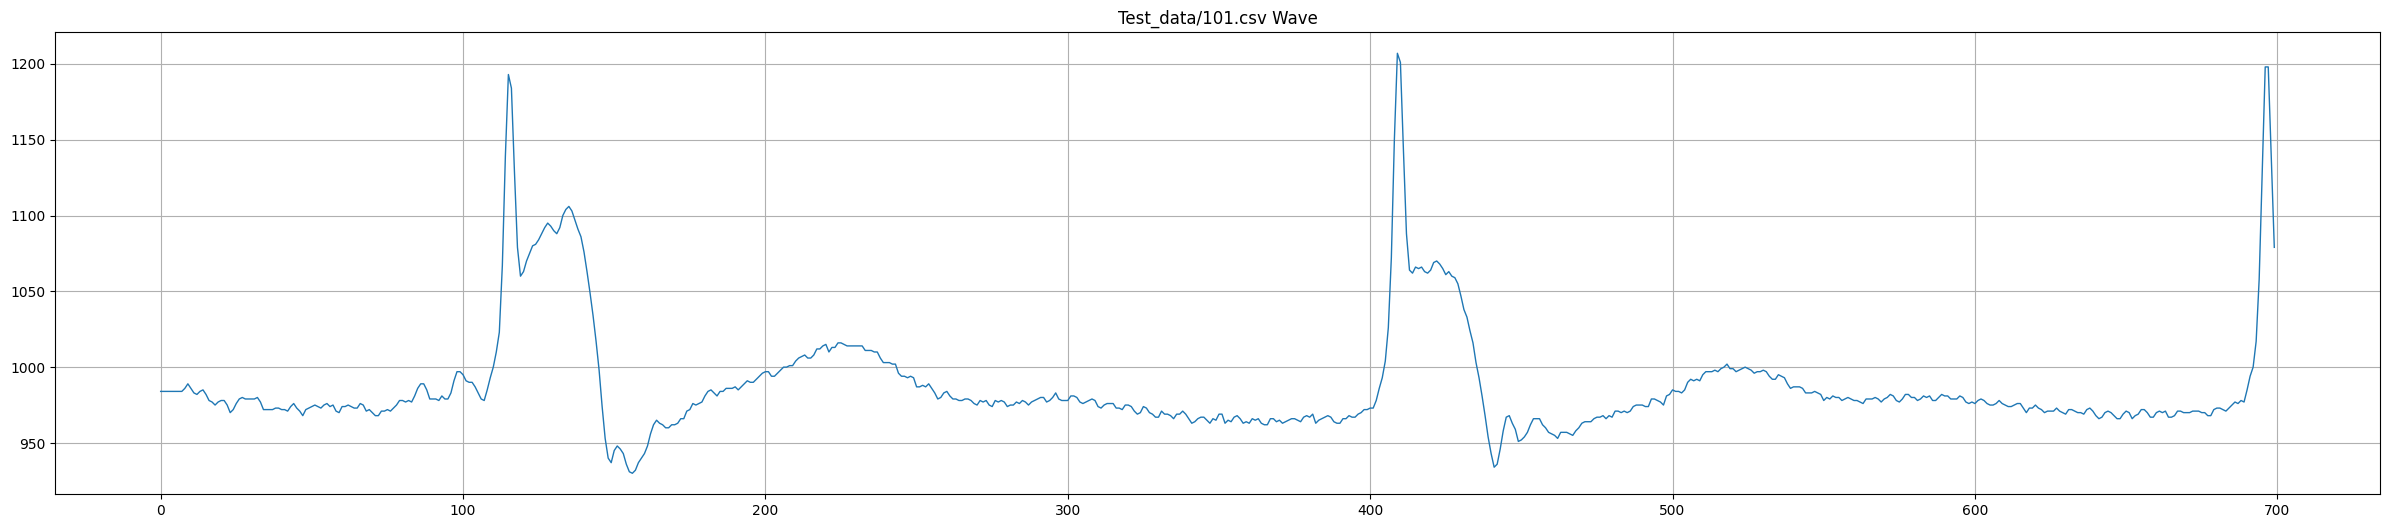

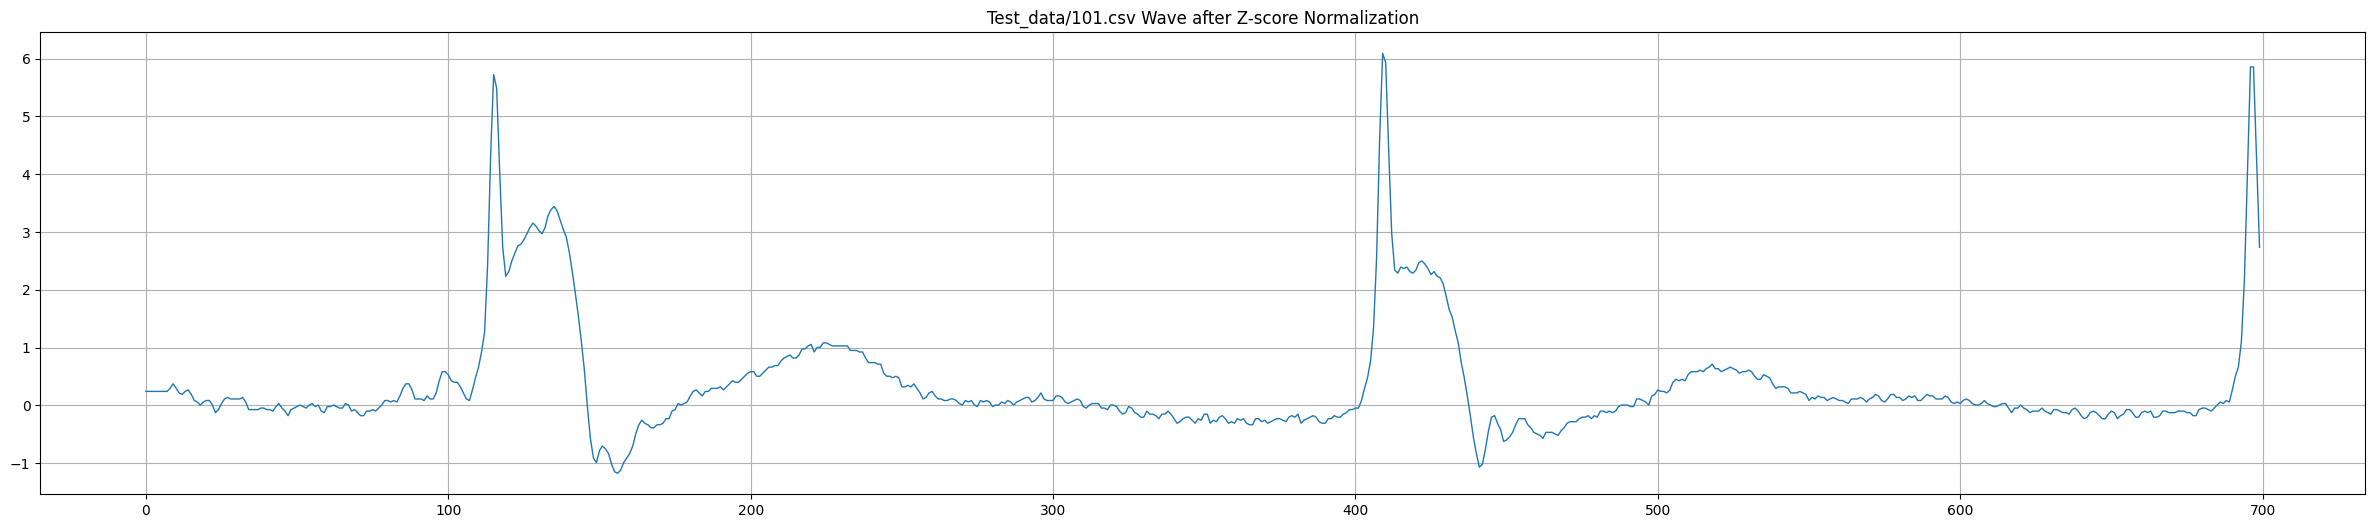

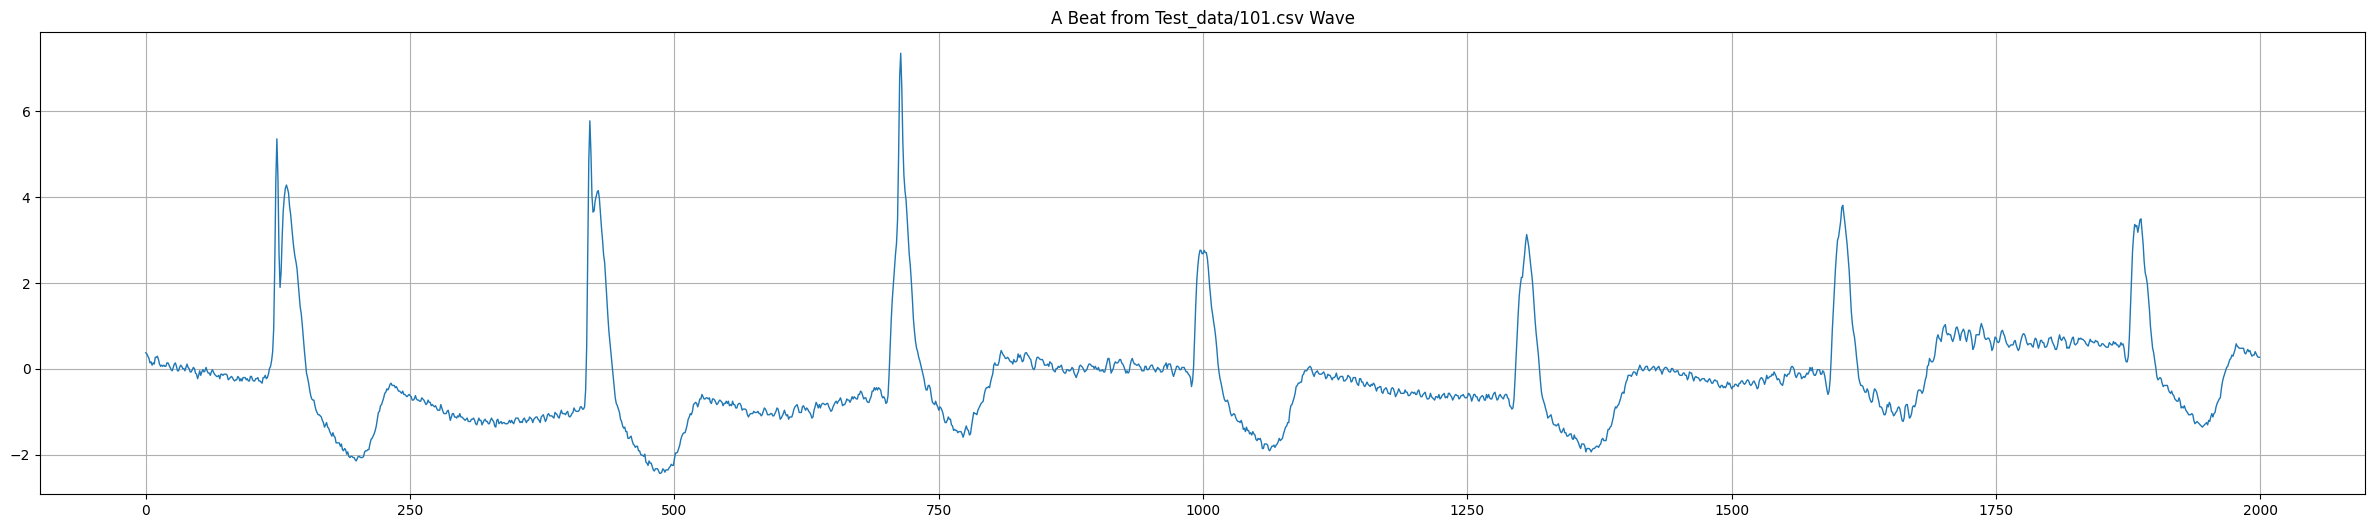

(17228, 2000) (17228,)
Class distribution: [11472, 2003, 2166, 174, 1465]


In [33]:
for r in range(len(records)):
    signals = []

    # Membaca file CSV dan mengambil sinyal
    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(spamreader)  # Skip header
        for row in spamreader:
            signals.append(int(row[1]))

    # Plot sinyal asli
    if r == 1:
        plt.title(f"{records[0]} Wave")
        plt.plot(signals[:700])
        plt.show()

    # Normalisasi sinyal menggunakan z-score
    signals = stats.zscore(signals)
    signals = add_ecg_noise(signals, noise_type='baseline_wander')

    # Plot sinyal setelah normalisasi
    if r == 1:
        plt.title(f"{records[0]} Wave after Z-score Normalization")
        plt.plot(signals[:700])
        plt.show()

    # Membaca anotasi dan mengekstrak beat
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        for d in range(1, len(data)):  # Skip header
            splitted = data[d].split()
            pos = int(splitted[1])  # Sample ID
            arrhythmia_type = splitted[2]  # Type

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1

                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size:pos + window_size]

                    # Plot contoh beat
                    if r == 1 and not example_beat_printed:
                        plt.title(f"A Beat from {records[0]} Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# Cetak bentuk data
print(np.shape(X), np.shape(y))
print("Class distribution:", count_classes)

In [34]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(17228, 2001)


In [35]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

"""plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()"""

2000
0.0    11436
2.0     2160
1.0     1995
4.0     1464
3.0      173
Name: count, dtype: int64


"plt.figure(figsize=(20,10))\nmy_circle=plt.Circle( (0,0), 0.7, color='white')\nplt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')\np=plt.gcf()\np.gca().add_artist(my_circle)\nplt.show()"

In [36]:
from sklearn.utils import resample

df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [37]:
print(X_train_df.shape)

(25000, 2001)


2000
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


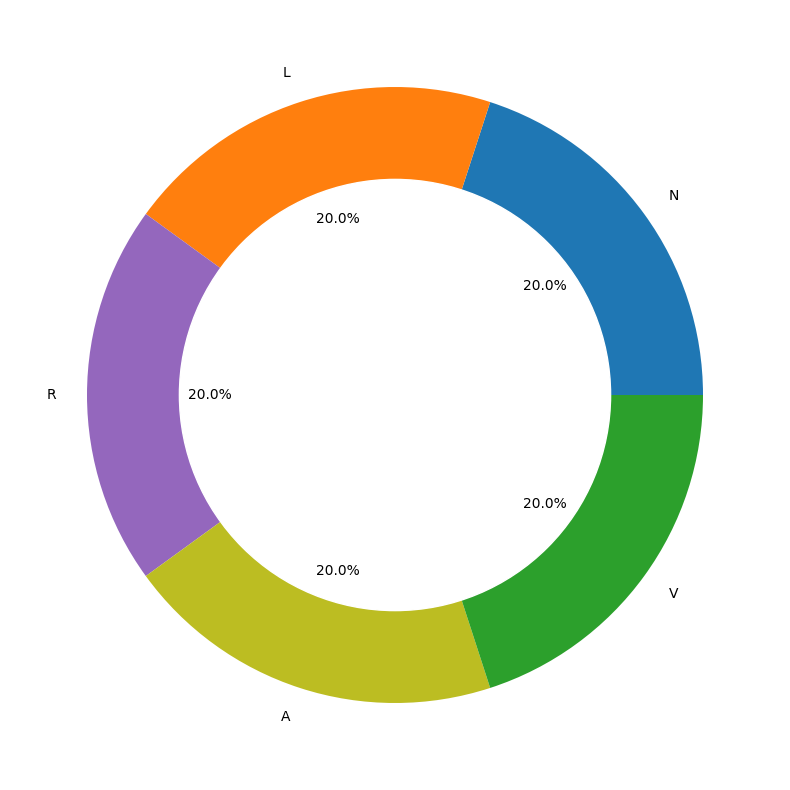

In [38]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [39]:
print(per_class.shape)

(5,)


In [40]:
print(X_train_df.shape)

(25000, 2001)


In [41]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X_train_df, test_size=0.2)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 2001)
X_test  :  (5000, 2001)


In [42]:
# Misal `train` dan `test` adalah dataframe
target_train = train.iloc[:, -1].values
target_test = test.iloc[:, -1].values

# --- One-hot encoding label ---
num_classes = len(np.unique(target_train))
#y_train = F.one_hot(torch.tensor(target_train), num_classes=num_classes).float()
y_train = F.one_hot(torch.tensor(target_train, dtype=torch.long), num_classes=num_classes).float()
#y_test = F.one_hot(torch.tensor(target_test), num_classes=num_classes).float()
y_test = F.one_hot(torch.tensor(target_test, dtype=torch.long), num_classes=num_classes).float()

print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# --- Ambil fitur (selain kolom label terakhir) ---
X_train = train.iloc[:, :-1].values
X_test = test.iloc[:, :-1].values

# --- Convert ke tensor dan reshape: (samples, timesteps, features) ---
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # tambahkan dimensi fitur
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

print("X_train:", X_train.shape)  # hasil: [samples, timesteps, 1]
print(f"X_test : {X_test.shape}")

y_train: torch.Size([20000, 5])
y_test : torch.Size([5000, 5])
X_train: torch.Size([20000, 2000, 1])
X_test : torch.Size([5000, 2000, 1])


In [43]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=4):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ECGTransformer(nn.Module):
    def __init__(self, configs, hparams):
        super(ECGTransformer, self).__init__()

        filter_sizes = [5, 9, 11]
        self.conv1 = nn.Conv1d(configs['input_channels'], configs['mid_channels'], kernel_size=filter_sizes[0],
                               stride=configs['stride'], bias=False, padding=(filter_sizes[0] // 2))
        self.conv2 = nn.Conv1d(configs['input_channels'], configs['mid_channels'], kernel_size=filter_sizes[1],
                               stride=configs['stride'], bias=False, padding=(filter_sizes[1] // 2))
        self.conv3 = nn.Conv1d(configs['input_channels'], configs['mid_channels'], kernel_size=filter_sizes[2],
                               stride=configs['stride'], bias=False, padding=(filter_sizes[2] // 2))
        
        self.bn = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.do = nn.Dropout(0.2)

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.inplanes = 128
        self.crm = self._make_layer(SEBasicBlock, 128, 3)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

        self.aap = nn.AdaptiveAvgPool1d(1)
        self.clf = nn.Linear(128, 5)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x_in):
        x1 = self.conv1(x_in)
        x2 = self.conv2(x_in)
        x3 = self.conv3(x_in)

        x_concat = torch.mean(torch.stack([x1, x2, x3], 2), 2)
        x_concat = self.do(self.mp(self.relu(self.bn(x_concat))))

        x = self.conv_block2(x_concat)
        x = self.conv_block3(x)

        x = self.crm(x)
        
        x = x.permute(0, 2, 1)
        x1 = self.transformer_encoder(x)
        x2 = self.transformer_encoder(torch.flip(x, [2]))
        x = x1 + x2
        x = x.permute(0, 2, 1)  

        x = self.aap(x)
        x_flat = x.reshape(x.shape[0], -1)
        x_out = self.clf(x_flat)
        return x_out


# Contoh penggunaan
configs = {
    "input_channels": 2000,
    "mid_channels": 32,
    "final_out_channels": 128,
    "trans_dim": 128,
    "num_heads": 8,
    "num_classes": 5,
    "dropout": 0.5,
    "stride":1
}

hparams = {
    "feature_dim": 128
}

In [48]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score  

In [51]:
labels = ['N', 'L', 'R', 'A', 'V']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGTransformer(configs, hparams).to(device)

# 🔁 Gunakan map_location untuk load model ke CPU jika tidak ada GPU
state_dict = torch.load('best_model.pth', map_location=device)
model.load_state_dict(state_dict)
model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for x_test_batch, y_test_batch in test_loader:
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        if y_test_batch.ndim == 2 and y_test_batch.size(1) > 1:
            y_test_batch = torch.argmax(y_test_batch, dim=1)

        outputs = model(x_test_batch)
        _, predicted = outputs.max(1)

        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(y_test_batch.cpu().numpy())

# Metrics
test_precision = precision_score(test_targets, test_preds, average='macro', zero_division=0)
test_recall = recall_score(test_targets, test_preds, average='macro', zero_division=0)
test_f1 = f1_score(test_targets, test_preds, average='macro', zero_division=0)

print("\n=== Test Set Evaluation ===")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1 Score:  {test_f1:.4f}")

# Classification report
print("\nClassification Report Arrhythmia Detection:")
print(classification_report(test_targets, test_preds, target_names=labels, zero_division=0))



=== Test Set Evaluation ===
Precision: 0.9720
Recall:    0.9701
F1 Score:  0.9700

Classification Report Arrhythmia Detection:
              precision    recall  f1-score   support

           N       0.90      0.99      0.94      1015
           L       0.98      0.99      0.98       953
           R       0.99      1.00      0.99      1034
           A       1.00      0.89      0.94      1033
           V       1.00      0.98      0.99       965

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

